In [1]:
import pandas as panda


from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report
from sklearn.linear_model import Perceptron, LogisticRegression

from matplotlib import pyplot as plot
import seaborn as sns


from numpy import bincount, linspace, mean, std

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
remote_location = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"


In [3]:
def downLoadData():
    """
    
    Downloads the excel data from remote location. Reads one particular sheet, converts all columns names 
    to lower case and then returns the data
    
    """

    data = panda.read_excel(remote_location,sheet_name = "Data", header = 1)

    data.rename(str.lower, inplace = True, axis = 'columns')

    print(data.dtypes)

    return data

data = downLoadData()

id                            int64
limit_bal                     int64
sex                           int64
education                     int64
marriage                      int64
age                           int64
pay_0                         int64
pay_2                         int64
pay_3                         int64
pay_4                         int64
pay_5                         int64
pay_6                         int64
bill_amt1                     int64
bill_amt2                     int64
bill_amt3                     int64
bill_amt4                     int64
bill_amt5                     int64
bill_amt6                     int64
pay_amt1                      int64
pay_amt2                      int64
pay_amt3                      int64
pay_amt4                      int64
pay_amt5                      int64
pay_amt6                      int64
default payment next month    int64
dtype: object


In [4]:
## check for varied data types. there may be alphabetical data types or numeric data written as string eg "4"".
## in such cases reformatting may be required
print(data.dtypes.value_counts()) ## all values are numeric and no formatting of data types are required in that case

int64    25
dtype: int64


In [5]:

## since all fields are numeric we can get away with normal describe. else we would have required describe(include='all')
data.describe()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000




There are simply 25 columns , all numeric values. No further feature selection or extraction may be required. We will go ahead and run algorithms deirectly and calculate accuracies.

However before we can do that we will check for class bias. Our target attribute is 'deaful', we will check for the value count for the same to see if our data sets is skewed towards one particular class. 

We can see there are almost 4times cases of non default versus default cases. Lets proceed with these analysis and check if we would require to account for class bias during model evaluation

Additionally, we would also drop the id column, since it adds no value other than row count


In [6]:
data['default payment next month'].value_counts()

data.drop(['id'], inplace=True, axis =1)

data.head(2)

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [7]:
## divide up our x and y axis

_y_target = data['default payment next month'].values

columns = data.columns.tolist()
columns.remove('default payment next month')

_x_attributes = data[columns].values


## meaning of stratify = _y_target. returns test and training data having the same proportions of class label '_y_target'
_x_train,_x_test,_y_train, _y_test = train_test_split(_x_attributes, _y_target, test_size =0.30, stratify = _y_target, random_state = 1)

## lets check the distribution. we can see 4times the lower value as was the case before as well. train/test set distributed well
print("label counts in y train %s" %bincount(_y_train))
print("label counts in y test %s" %bincount(_y_test))

label counts in y train [16355  4645]
label counts in y test [7009 1991]


In [8]:
## cv is essentially value of K in k fold cross validation
    
## n_jobs = 1 is  non parallel execution    , -1 is all parallel , any other number say 2 means execute in 2 cpu cores

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()

We will create a list of classifiers and compare performance. The algorithms selected for classification are as below:

1. Perceptron
2. SVM
3. Logistic Regression
4. SVM Kernel RBF
5. DecisionTrees
5. RandomForest
6. Nearest Neighbour




{'perceptron__eta0': 0.5, 'perceptron__max_iter': 8}
0.7795238095238095
Accuracy score 0.5882222222222222
Classification report  
              precision    recall  f1-score   support

          0       0.78      0.66      0.71      7009
          1       0.22      0.35      0.27      1991

avg / total       0.66      0.59      0.62      9000



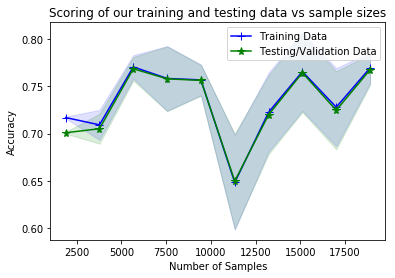

In [11]:

parameter_grid = {'perceptron__max_iter': [1,5,8,10], 'perceptron__eta0': [0.5,.4, .2, .1]}

pipeline = make_pipeline( StandardScaler(),Perceptron(random_state = 1))
gridsearch = GridSearchCV(estimator = pipeline, param_grid = parameter_grid, cv = 10, n_jobs = 1, scoring = 'accuracy')

search = gridsearch.fit(_x_train, _y_train)
print(search.best_params_)
print(search.best_score_)
perceptron = Perceptron(max_iter = 8, eta0 = 0.5, random_state = 1)

pipeline = make_pipeline( StandardScaler(),perceptron)
pipeline.fit(_x_train,_y_train)
_y_prediction = pipeline.predict(_x_test)


print("Accuracy score %s" %pipeline.score(_x_test,_y_test))
print("Classification report  \n %s" %(classification_report(_y_test, _y_prediction)))
plotLearningCurve(_x_train, _y_train, pipeline)


Accuracy score 0.811
Classification report  
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      7009
          1       0.71      0.25      0.37      1991

avg / total       0.80      0.81      0.77      9000



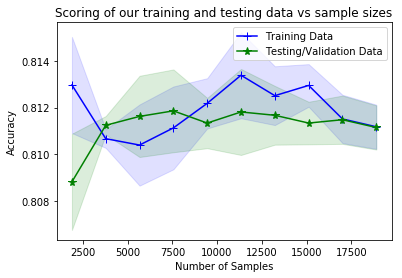

In [10]:

## we dont have test_train_split again, since StandardScaler has default copy=True, meaning alterations are done on copies

logistic_regression = LogisticRegression(C = 110,  random_state = 1) ## c being inverse of regularization param

pipeline = make_pipeline( StandardScaler(), logistic_regression)
pipeline.fit(_x_train,_y_train)
_y_prediction = pipeline.predict(_x_test)

print("Accuracy score %s" %pipeline.score(_x_test,_y_test))
print("Classification report  \n %s" %(classification_report(_y_test, _y_prediction)))
plotLearningCurve(_x_train, _y_train, pipeline)